# **67818 Ex2 - Daniel Busbib**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from copy import deepcopy
import folium, io
from folium.plugins import HeatMap, MarkerCluster
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from google.colab import files

In [6]:
file_name = "ex1.csv"
# uploaded = files.upload()
# data = pd.read_csv(io.BytesIO(uploaded[file_name]))
data = pd.read_csv(file_name)

Saving ex1.csv to ex1 (1).csv


# Q1 (a)

In [7]:
data.head()

,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,gun_stolen,...,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,state_house_district,state_senate_district
0,0,137007,2016-07-23,Utah,Draper,12300 South,0,1,4.0,NaN,...,Man wanted for prior agg asault shot self in h...,0::30,0::Adult 18+,0::Male,0::Eddie Heuser,NaN,0::Injured,0::Subject-Suspect,51.0,11.0
1,1,49807,2014-12-13,-1,Chicago,10400 block of South State Street,-1,0,2.0,0::Unknown,...,"Man shot, drive-by;",0::26,0::Adult 18+,0::Male,0::Tyrece L. Stornes,NaN,0::Killed,0::Victim,28.0,14.0
2,2,2318,2014-01-15,south carolina,Irmo,1 Forest Walk Court,4,0,2.0,NaN,...,NaN,0::28||1::3||2::1||3::38,0::Adult 18+||1::Child 0-11||2::Child 0-11||3:...,0::Female||1::Male||2::Female||3::Male,0::Kia Miller||1::Kyler Devane Miller||2::Syra...,3::Family,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,73.0,19.0
3,3,237635,2018-03-18,-1,Detroit,5600 BLOCK OF JOHN C LODGE FWY,0,0,NaN,0::Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,238068,2018-03-21,Michigan,Benton Harbor,1200 block of Parkway Dr,0,0,6.0,0::Stolen,...,"raid, drug, stolen handgun",0::34||1::39||2::31||3::47,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male,0::Sylvester Davis III||1::Leonard Robinson||2...,NaN,"0::Unharmed, Arrested||1::Unharmed, Arrested||...",0::Subject-Suspect||1::Subject-Suspect||2::Sub...,79.0,21.0


In [8]:
data.nunique()

Unnamed: 0                  23967
incident_id                 23967
date                         1571
state                         103
city_or_county               4175
address                     21625
n_killed                       11
n_injured                      21
congressional_district         54
gun_stolen                    116
gun_type                      491
incident_characteristics     3705
latitude                    16038
location_description         3455
longitude                   20785
n_guns_involved                48
notes                       14739
participant_age              3452
participant_age_group         248
participant_gender            251
participant_name            11560
participant_relationship      106
participant_status            590
participant_type              115
state_house_district          213
state_senate_district          67
dtype: int64

I choose the feature `congressional_district` as categorial feature and made the same process shown in class, based on the geographic coordinate system features.


In [9]:
# as shown in class - train random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

CT = "congressional_district"
features = ["state", "city_or_county", "state_house_district", "state_senate_district"]
X = data[["state", "city_or_county", "congressional_district", "state_house_district", "state_senate_district"]]
X = pd.get_dummies(X, columns=features, drop_first=True)
X = X[~X[CT].isnull()]
y = X[CT]
X = X.drop(columns=[CT])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf = RandomForestRegressor(100,max_depth=15)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=15)

In [11]:
rf.score(X_test,y_test)

0.5477977881138019

In [12]:
new_data = deepcopy(data)
X = pd.get_dummies(new_data[features], columns=features, drop_first=True)
null_indices = new_data["congressional_district"].isna()
prediction = rf.predict(X[null_indices])
new_data.loc[null_indices, CT] = prediction

In [13]:
new_data[CT].isna().sum()

0

For the continuous feature i choose `longitude` feature.

In [ ]:
new_data["longitude"].isna().sum()

775

I choose for the imputation on `longitude` to take the average longitude of the data samples but with the same `state` and `city_or_country`. The reason is because longitude is a very specific geographical feature that we have in the data(like city, latitude..).

In [14]:
LT = "longitude"
STATE = "state"
CC = "city_or_county"
mapping_table = new_data[~new_data[LT].isna()].groupby([STATE, CC]).mean()[LT]
minor_mapping_table = new_data[~new_data[LT].isna()].groupby([STATE]).mean()[LT]
missing_indices = new_data[new_data[LT].isna()][LT].index

In [15]:
def mapF(i):
  state = new_data.loc[i][STATE]
  city = new_data.loc[i]["city_or_county"]
  return mapping_table[state][city] if city in mapping_table[state] else minor_mapping_table[state]

In [16]:
maplg = pd.Series(map(mapF, missing_indices),
                    index=missing_indices)
new_data.loc[new_data[LT].isna(), LT] = maplg
new_data[LT].isna().sum()

0

(b)

I choose to add `isWeekend` feature as a binnig of the `date` column.<br>
Because I think the date is not very beneficial to the model, and maybe in the weekend's days there are more crime.<br>
Other features that are bining of the `date` are year, month, day, etc.

In [19]:
data_b = deepcopy(new_data)
data_b["isWeekend"] = pd.to_datetime(new_data['date']).apply(lambda date: 1 if (date.weekday() + 1) % 7 > 4 else 0 )

In [20]:
data_b.head()

,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,gun_stolen,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,state_house_district,state_senate_district,isWeekend
0,0,137007,2016-07-23,Utah,Draper,12300 South,0,1,4.00000,NaN,...,0::30,0::Adult 18+,0::Male,0::Eddie Heuser,NaN,0::Injured,0::Subject-Suspect,51.0,11.0,1
1,1,49807,2014-12-13,-1,Chicago,10400 block of South State Street,-1,0,2.00000,0::Unknown,...,0::26,0::Adult 18+,0::Male,0::Tyrece L. Stornes,NaN,0::Killed,0::Victim,28.0,14.0,1
2,2,2318,2014-01-15,south carolina,Irmo,1 Forest Walk Court,4,0,2.00000,NaN,...,0::28||1::3||2::1||3::38,0::Adult 18+||1::Child 0-11||2::Child 0-11||3:...,0::Female||1::Male||2::Female||3::Male,0::Kia Miller||1::Kyler Devane Miller||2::Syra...,3::Family,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,73.0,19.0,0
3,3,237635,2018-03-18,-1,Detroit,5600 BLOCK OF JOHN C LODGE FWY,0,0,8.27762,0::Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,238068,2018-03-21,Michigan,Benton Harbor,1200 block of Parkway Dr,0,0,6.00000,0::Stolen,...,0::34||1::39||2::31||3::47,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male,0::Sylvester Davis III||1::Leonard Robinson||2...,NaN,"0::Unharmed, Arrested||1::Unharmed, Arrested||...",0::Subject-Suspect||1::Subject-Suspect||2::Sub...,79.0,21.0,0


# Q3 (a)

In [21]:
file_name = "ex2.csv"
# uploaded = files.upload()
# data2 = pd.read_csv(io.BytesIO(uploaded[file_name]))
data2 = pd.read_csv(file_name)

Saving ex2.csv to ex2.csv


In [22]:
data2.columns

Index(['Unnamed: 0', 'incident_id', 'date', 'state', 'city_or_county',
       'address', 'n_killed', 'n_injured', 'congressional_district',
       'gun_stolen', 'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'state_house_district', 'state_senate_district'],
      dtype='object')

First, I will add the mean number of guns involved in incidents of a state, this might be good to predict the number of people killed.

In [23]:
state_mean_guns_inv = data2.groupby("state").mean()["n_guns_involved"]
data2["state_mean_guns_inv"] = data2["state"].apply(lambda state: state_mean_guns_inv[state])

Next, I add the feature of total physic damage in the incident, the number of people killed and the number of people injured in a single incident.<br>
I think it might help predict the number of guns involved, because maybe more the damage in an incident the more guns involved.

In [24]:
data2["total_damage"] = data2['n_killed'] + data2['n_injured']

(b)

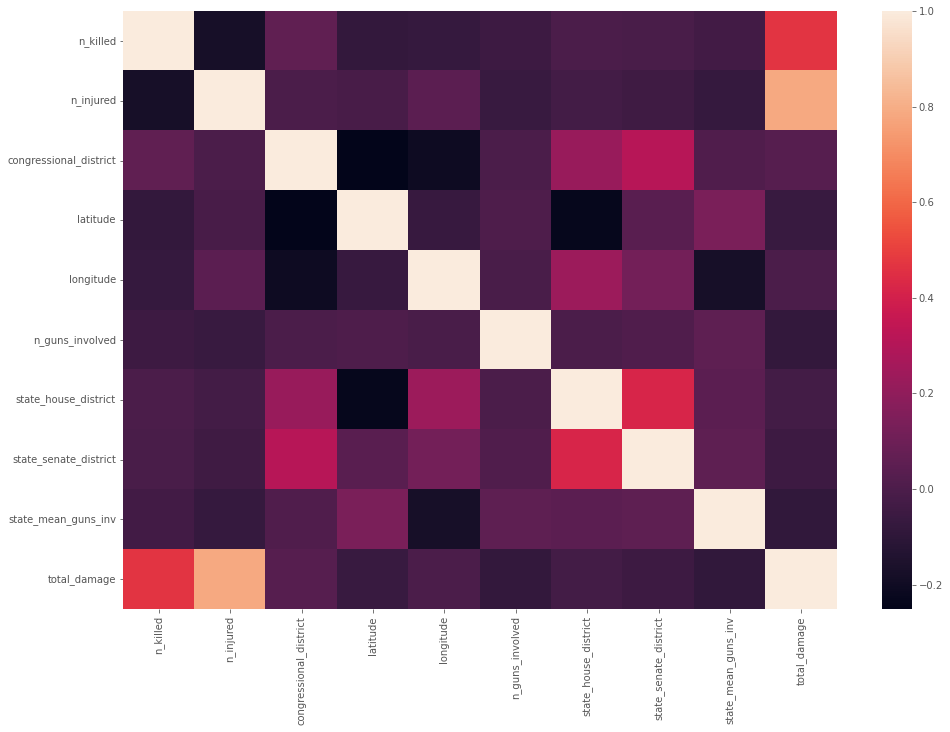

In [25]:
data2.drop(["Unnamed: 0", "incident_id"], axis="columns", inplace=True)
plt.figure(figsize=(16, 11))
sns.heatmap(data2.corr())
plt.show()

I can see from the heatmap that there is a high correlation between `total_damage` and `n_injured` and `n_killed`, because `total_damage` is an interaction of them.

Suprisingly, the feature `state_mean_guns_inv` is not very correlative with another feature,
even with `n_injured` and `n_killed`.

# Q4 (a)

In [26]:
file_name = "covid_data.csv"
# uploaded = files.upload()
# covid_data = pd.read_csv(io.BytesIO(uploaded[file_name]))
covid_data = pd.read_csv(file_name)

Saving covid_data.csv to covid_data.csv


In [27]:
covid_data.columns

Index(['day_num', 'date', 'detected'], dtype='object')

Now I fit a linear regression model using the day feature to predict the
amount of new detected cases.

In [28]:
X, y= covid_data[["day_num"]], covid_data["detected"]
LR = LinearRegression()
LR.fit(X, y)

LinearRegression()

The MSE:

In [29]:
mean_squared_error(y, LR.predict(X))

1669656.317944683

(b)

Plot the true and predict label function

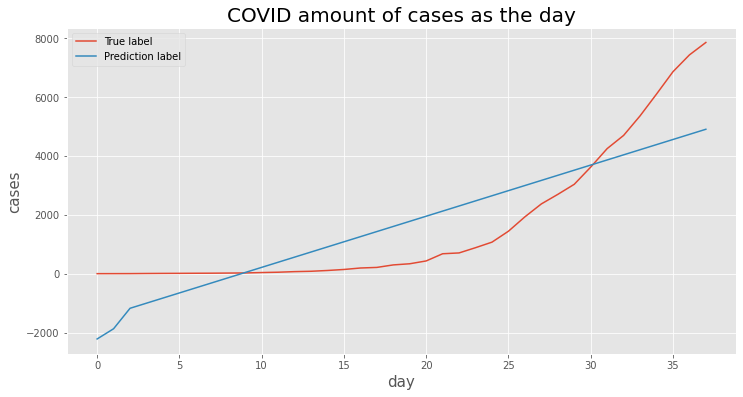

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y, label="True label")
plt.plot(LR.predict(X), label="Prediction label")
plt.title("COVID amount of cases as the day", fontsize=20)
plt.xlabel("day", fontsize=15)
plt.ylabel("cases", fontsize=15)
plt.legend()
plt.show()

As shown in the plot, the connection  between the day feature to the amount of cases is not very linear.<br>
It starts as a horizontal line and then it first increases slowly and then the growth becomes rapid and we are getting high values, looks like the exp graph. Maybe it says that more we count the days then the amount of cases is getting high exponentially, but it is unsure that this is the real case.<br>
The connection may be exponential or squared.<br>


(c)

* Square Root Transformation

In [32]:
X1, y1 = covid_data[["day_num"]], np.sqrt(covid_data["detected"])
LR1= LinearRegression()
LR1.fit(X1, y1)

LinearRegression()

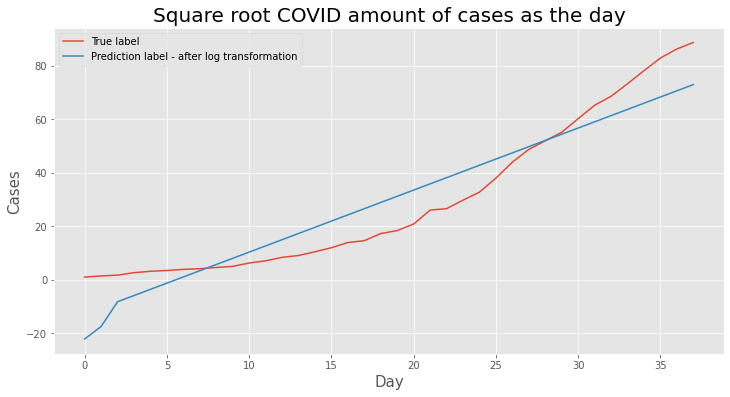

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(y1, label="True label")
plt.plot(LR1.predict(X1), label="Prediction label - after log transformation")
plt.legend()
plt.title("Square root COVID amount of cases as the day", fontsize=20)
plt.xlabel("Day", fontsize=15)
plt.ylabel("Cases", fontsize=15)
plt.show()

In [ ]:
mean_squared_error(y1, LR1.predict(X1))

98.83289823694948

As we can see by the MSE recorded in this case, indeed the square root transformation give us better result.

* Log Transformation

In [34]:
X2, y2 = covid_data[["day_num"]], np.log(covid_data["detected"])
LR2= LinearRegression()
LR2.fit(X2, y2)

LinearRegression()

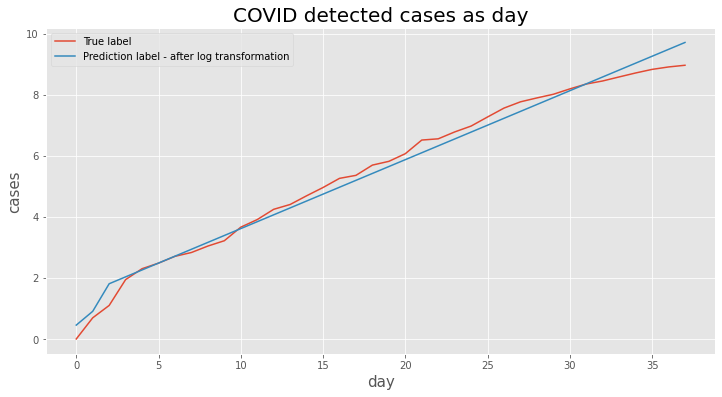

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y2, label="True label")
plt.plot(LR2.predict(X2), label="Prediction label - after log transformation")
plt.legend()
plt.title("COVID detected cases as day", fontsize=20)
plt.xlabel("day", fontsize=15)
plt.ylabel("cases", fontsize=15)
plt.show()

I can clearly see that the connection became more linear.

In [37]:
mean_squared_error(y2, LR2.predict(X2))

0.08197842668518304

**conclusion:** The log transformation gives me the best results!